## Objective
Implement a Variational Autoencoder to generate new realistic images of clothing apparels by training on fashion-MNIST dataset from keras.

In [2]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [3]:
# Loading Data
from keras.datasets import fashion_mnist

(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()

# Undo the train-test-split
X= np.concatenate([X_train,X_test],axis=0)
y =np.concatenate([y_train,y_test])

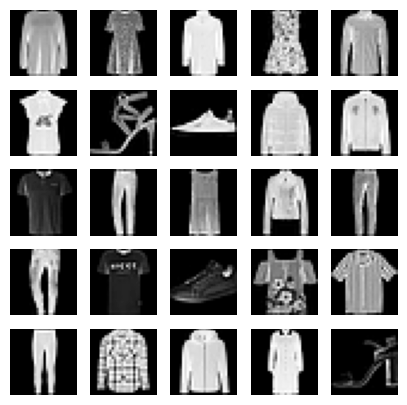

In [4]:
# Sample a few fashion MNIST images from the data and view the images
indices = np.random.randint(0,X.shape[0],size=25)

images =X[indices]

plt.figure(figsize=(5,5))

for i in np.arange(0,len(indices),1):
    plt.subplot(5,5,i+1)
    image=images[i]
    plt.imshow(image,cmap='gray')
    plt.axis('off')

In [5]:
# Shape of data
X.shape

(70000, 28, 28)

## Building a VAE

### 1. Sampler

In [8]:
# The purpose of this Sampler class is to create random noise vector belonging to latent space
class Sampler(layers.Layer):
    def call(self,inputs):
        # Obtain the mean and variance of the latent space vectors from previous layers
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim= tf.shape(z_mean)[1]

        # Introduce slight variations in latent space
        epilson = tf.random.normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var) * epilson

### 2. Encoder

In [10]:
# The encoder converts the orignal images into a smaller latent space vector and learns the transformation function

# Choose the dimensionality of the latent space
latent_dim=2

# Specify the input data shape
encoder_inputs = keras.Input(shape=(28,28,1))

# Add a convolutional layer
x = layers.Conv2D(filters =32, kernel_size=3, activation='relu', strides =2, padding ='same')(encoder_inputs)

# Add a convolutional layer
x = layers.Conv2D(filters =63, kernel_size=3, activation='relu', strides =2, padding ='same')(x)

# Flatten the feature map into a 1d array
x= layers.Flatten()(x)

# Add a dense layer
x = layers.Dense(units=16,activation='relu')(x)

# Add computational layers to obtain the mean and variance of the vectors in the latent space
z_mean = layers.Dense(units=latent_dim,name='z_mean')(x)
z_log_var = layers.Dense(units=latent_dim,name='z_log_var')(x)

# Add a sampling layer
z= Sampler()([z_mean,z_log_var])

#Combine all the layers into a single model
encoder= keras.Model(inputs=encoder_inputs,outputs=[z_mean,z_log_var],name='encoder')

# generate summary
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 63)  │     18,207 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3087)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     49,408 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,003 (265.64 KB)

 Trainable params: 68,003 (265.64 KB)

 Non-trainable params: 0 (0.00 B)

### 3. Decoder

In [12]:
# The decoder converts the latent space vector into the original image space and learns transformation

#Specify the shape of the input to the decoder
latent_inputs = keras.Input(shape=(latent_dim,))

# Add a dense layer
x = layers.Dense(units=7*7*64, activation='relu')(latent_inputs)

# Add a reshaping layer
x= layers.Reshape((7,7,64))(x)

# Add a transpose convolution layer
x = layers.Conv2DTranspose(filters =64, kernel_size=3, activation='relu', strides =2, padding ='same')(x)

# Add a transpose convolutional layer
x = layers.Conv2DTranspose(filters =32, kernel_size=3, activation='relu', strides =2, padding ='same')(x)

# Add an output transpose convolutional layer
decoder_outputs = layers.Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid',padding='same')(x)

# Combine all the layers into a single model
decoder = keras.Model(inputs=latent_inputs,outputs=decoder_outputs,name='decoder')

# generate summary
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## VAE

In [14]:
# Create a new model class and define the VAE with a custom training step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)

        # Add the encoder and decoder to the model
        self.encoder = encoder
        self.decoder = decoder

        # Define various loss metrics required for training
        self.total_loss_tracker = keras.metrics.Mean(name = 'total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = 'reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name = 'kl_loss')

    # Create property attribute to return the loss values
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    # Describe the parameter update process based on the loss values
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Obtain a random vector from the latent space
            z_mean, z_log_var, z = self.encoder(data)

            # Generate an image using the random vector
            reconstruction = self.decoder(z)

            # Calculate the losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss

        # Update parameters and loss atteributes
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Return the loss values
        return {'loss': self.total_loss_tracker.result(),
                'reconstruction_loss': self.reconstruction_loss_tracker.result(),
                'kl_loss': self.kl_loss_tracker.result()}

In [15]:
vae =VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate =0.0005))

## Training VAE

In [17]:
vae.fit(X,epochs=5, batch_size=256)

Epoch 1/5


ValueError: not enough values to unpack (expected 3, got 2)